# 12.2. Causality

### causation
- The key to the analysis of randomized controlled experiments is understanding exactly how chance enters the picture. This helps us set up clear null and alternative hypotheses. 

## 12.2.1. Treating Chronic Back Pain: A Randomized Controlled Trial

- A randomized controlled trial (RCT) examined the effect of using Botulinum Toxin A (BTA, **Botox**) as a treatment
- Thirty one patients with low-back pain were randomized into treatment and control groups, with **15 in the treatment/experiment group and 16 in control**.
- The control group was given normal **saline**, and the trials were run **double-blind** so that neither doctors nor patients knew which group they were in.

In [5]:
from datascience import *
path_data = '../../data/'


# bta = Table().read_table(path_data + 'bta.csv')
bta = Table.read_table(path_data + 'bta.csv')
bta.show(5)

### 1 == relief
### The sum of 1’s in the control group is the number of control group patients who had pain relief

Group,Result
Control,1
Control,1
Control,0
Control,0
Control,0


In [22]:
bta.group('Group')          ### count number of values

Group,count
Control,16
Treatment,15


In [7]:
### pass a function to group()
bta.group('Group', sum)     ### tbl.group(column_or_columns) groups a table by values in column_or_columns.
                            ### tbl.group(column_or_columns, func) 
                                ### func takes in an array of values and returns a single value
                            ### Control has two groups
### sum: Treatment group has a lot more pain relief. 

Group,Result sum
Control,2
Treatment,9


In [23]:
### sum == counting --> proportion
import numpy as np

### 2/16 == .125; 9/15 == .6
### In the treatment group, 60% of the patients had pain relief, 
### compared to only 12.5% in the control group. None of the patients suffered any side effects.
### we see that toxin A is better than saline, but could this be because of chance?
### maybe some patients are just better able to recover than others, even without treatment?
### for those people, saline would work as good as toxin A
bta.group('Group', np.average)   ##### instead of sum, do average

Group,Result average
Control,0.125
Treatment,0.6


## 12.2.2. Potential Outcomes

- **two potential outcomes**: the outcome that the patient would have if assigned to the treatment group, and the outcome that the same patient would have if assigned to the control group.
- The theory is: if a patient is assigned to a different group, the result should be different.
- There are 31 potential treatment oucomes and 31 potential control outcomes
- tbl observed_outcomes

In [24]:
observed_outcomes = Table.read_table(path_data + "observed_outcomes.csv")
observed_outcomes.show()
### this is the same tbl as bta with different format but same information

Group,Outcome if assigned treatment,Outcome if assigned control
Control,Unknown,1
Control,Unknown,1
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0


## 12.2.3. The Hypotheses

- question: does the treatment does anything?
- In terms of the table observed_outcomes, the question is whether the distribution of the 31 “treatment” values in Column 1 (including the unknown ones) is different from the distribution of the 31 “control” values in Column 2 (again including the unknown ones).
- **Null Hypothesis**: The **distribution** of all 31 potential “treatment” outcomes is the **same** as that of all 31 potential “control” outcomes. Botulinum toxin A does nothing different from saline; the difference in the two samples is just due to chance.
- **Alternative Hypothesis**: The **distribution** of 31 potential “treatment” outcomes is **different** from that of the 31 control outcomes. The treatment does something different from the control.
- You may assume that the treatement is **better** than the control.
- **If the null hypothesis were true, it wouldn’t matter which of those 31 outcomes were labeled “treatment” and which “control.”** Any random subset of 16 out of the 31 values could be called “control” and the remaining 15 “treatment”.
- We can **simulate** this. We can **randomly permute** the 31 values, split them into two groups of 16 and 15, and see how different the distributions in the two groups are. Since the data are zeros and ones, we can just see how different the two proportions are.
- That’s exactly what we did for A/B testing in the previous section. Sample A is now the control group and Sample B the treatment group. 

## 12.2.4. The Test Statistic

- If the two group proportions are very different from each other, we will lean towards the alternative hypothesis that the two underlying distributions are different. So our test statistic will be the distance between the two group proportions, that is, the absolute value of the difference between them.
- Large values of the test statistic will favor the alternative hypothesis over the null.
- Since the two group proportions were 0.6 and 0.125, the observed value of the test statistic is | 0.6 - 0.125 | = 0.475


In [10]:
bta.group('Group', np.average)

Group,Result average
Control,0.125
Treatment,0.6


In [11]:
observed_proportions = bta.group('Group', np.average).column(1)
observed_distance = abs(observed_proportions.item(0) - observed_proportions.item(1))
observed_distance     ##### observed data, not simulated

0.475

In [12]:
### the name of the table of data
### the column label of the group labels

def distance(table, group_label):
    reduced = table.select('Result', group_label)
    proportions = reduced.group(group_label, np.average).column(1)   ### average of 1's
    return abs(proportions.item(1) - proportions.item(0))

In [13]:
distance(bta, 'Group')

0.475

## 12.2.5. Predicting the Statistic Under the Null Hypothesis

- We can simulate results under the null hypothesis, to see how our test statistic should come out if the null hypothesis is true.


### 12.2.5.1. Generating One Value of the Statistic


In [14]:
shuffled_labels = bta.sample(with_replacement=False).column(0)   ### 'Group' (control/ treatment)

In [15]:
bta_with_shuffled_labels = bta.with_column('Shuffled Label', shuffled_labels)
bta_with_shuffled_labels.show(5)

Group,Result,Shuffled Label
Control,1,Control
Control,1,Treatment
Control,0,Treatment
Control,0,Treatment
Control,0,Control


In [16]:
### the distance of this distribution
distance(bta_with_shuffled_labels, 'Shuffled Label')

0.041666666666666685

### 12.2.5.2. Permutation Test

- If we shuffled the labels again, how different would the new distance be? 

In [17]:
def one_simulated_distance():
    shuffled_labels = bta.sample(with_replacement=False).column('Group')   ### new, simulated, a new group column
    shuffled_table = bta.select('Result').with_column('Shuffled Label', shuffled_labels)
    return distance(shuffled_table, 'Shuffled Label')

In [18]:
distances = make_array()
repetitions = 20000

for i in np.arange(repetitions):
    new_distance = one_simulated_distance()
    distances = np.append(distances, new_distance)

In [19]:
distances

array([ 0.04166667,  0.0875    ,  0.0875    , ...,  0.21666667,
        0.0875    ,  0.0875    ])

## 12.2.6. Conclusion of the Test

Observed Distance 0.475


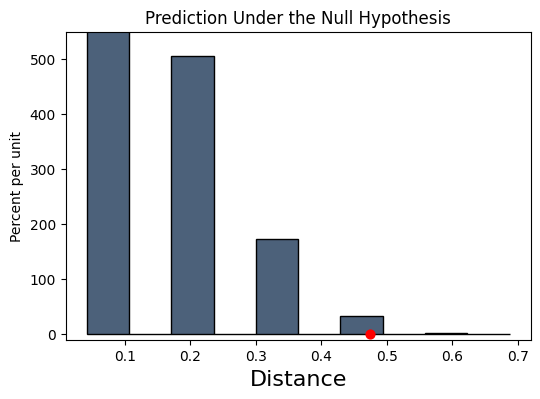

In [20]:
import matplotlib.pyplot as plots
%matplotlib inline

Table().with_column('Distance', distances).hist()
plots.ylim(-0.1, 5.5)
plots.scatter(observed_distance, 0, color='red', s=40, zorder=3)
plots.title('Prediction Under the Null Hypothesis')
print('Observed Distance', observed_distance)

In [21]:
empirical_p = np.count_nonzero(distances >= observed_distance) / repetitions
empirical_p

0.00815

- This is a small p-value. The observed statistic is in the tail of the empirical histogram of the test statistic generated under the null hypothesis.
- The result is statistically significant. The test favors the alternative hypothesis over the null. The evidence supports the hypothesis that the treatment is doing something.
- The study reports a P-value of 0.009, or 0.9%, which is not far from our empirical value.

## 12.2.7. Causality

- Because the trials were randomized, the test is evidence that the treatment causes the difference. The random assignment of patients to the two groups ensures that there is no confounding variable that could affect the conclusion of causality.
- If the treatment had not been randomly assigned, our test would still point toward an association between the treatment and back pain outcomes among our 31 patients. But beware: without randomization, this association would not imply that the treatment caused a change in back pain outcomes. For example, if the patients themselves had chosen whether to administer the treatment, perhaps the patients experiencing more pain would be more likely to choose the treatment and more likely to experience some reduction in pain even without medication. Pre-existing pain would then be a confounding factor in the analysis.